<a href="https://colab.research.google.com/github/christinatongtong/ToF_data_training/blob/main/all_shapes_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu
Epoch 01:  Reg MSE  train 332.8837 | test 298.2331   ||  Cls ACC  train   5.3% | test   7.0%
Epoch 02:  Reg MSE  train 287.7687 | test 266.7205   ||  Cls ACC  train  10.6% | test   6.6%
Epoch 03:  Reg MSE  train 262.8543 | test 246.8568   ||  Cls ACC  train  12.8% | test  12.5%
Epoch 04:  Reg MSE  train 244.1487 | test 230.2628   ||  Cls ACC  train  12.7% | test  12.5%
Epoch 05:  Reg MSE  train 227.8092 | test 215.3582   ||  Cls ACC  train  14.6% | test  12.9%
Epoch 06:  Reg MSE  train 213.1522 | test 201.8579   ||  Cls ACC  train  15.0% | test  12.9%
Epoch 07:  Reg MSE  train 199.6360 | test 189.5690   ||  Cls ACC  train  16.7% | test  19.1%
Epoch 08:  Reg MSE  train 187.3846 | test 178.2318   ||  Cls ACC  train  20.3% | test  19.9%
Epoch 09:  Reg MSE  train 175.9211 | test 167.8344   ||  Cls ACC  train  22.4% | test  19.5%
Epoch 10:  Reg MSE  train 165.5110 | test 158.3962   ||  Cls ACC  train  24.2% | test  15.2%
Epoch 11:  Reg MSE  train 155.9425 | test 149.9150   ||  C

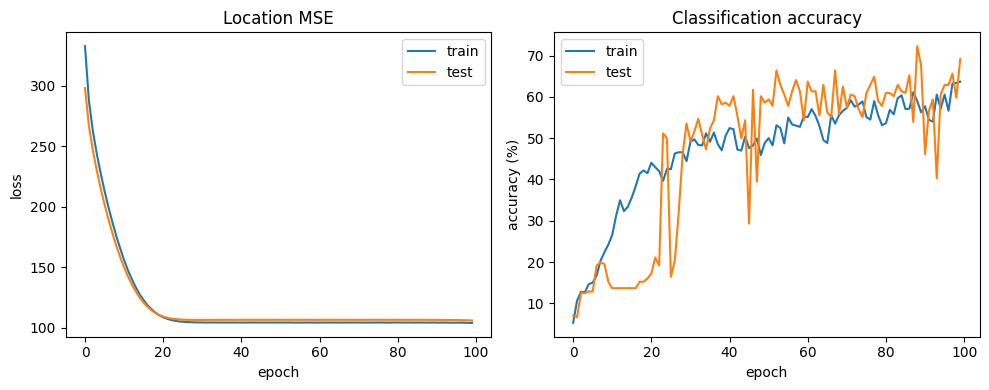

In [ ]:
# ---------------------------------------------------------------
# 0.  Imports
# ---------------------------------------------------------------
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt, random


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------------------------------------------------------
# 1.  Load data
# ---------------------------------------------------------------
X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")

assert X_train.ndim == 3 and X_train.shape[1:] == (9, 128), "X_train shape mismatch"
assert Y_train.shape[1] == 3, "Y_train must have 3 columns (x, y, class_id)"

# ensure float32 for PyTorch
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

# ---------------------------------------------------------------
# 2.  Split labels → loc   &   class
# ---------------------------------------------------------------
loc_np   = Y_train[:, :2]                # (n, 2)
class_np = Y_train[:,  2].astype(int)    # (n,)  ints
n_classes = int(class_np.max()) + 1
# ---------------------------------------------------------------
# 3.  →  PyTorch tensors & dataset
# ---------------------------------------------------------------
X_t  = torch.tensor(X_train, dtype=torch.float32)
loc_t= torch.tensor(loc_np, dtype=torch.float32)
cls_t= torch.tensor(class_np, dtype=torch.long)

dataset = TensorDataset(X_t, loc_t, cls_t)

# ---------------------------------------------------------------
# 4.  Train / test split & DataLoaders
# ---------------------------------------------------------------
TEST_PCT, BATCH = 0.2, 128
n_test   = int(len(dataset)*TEST_PCT)
n_train  = len(dataset) - n_test
train_set, test_set = random_split(dataset, [n_train, n_test],
                                   generator=torch.Generator())

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH)

# ---------------------------------------------------------------
# 5.  Models
# ---------------------------------------------------------------
class Featurizer(nn.Module):
    """Shared feature extractor: flatten → 2 FC layers"""
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                           # 9*128 = 1152
            nn.Linear(1152, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
    def forward(self, x): return self.net(x)


class Featurizer_Better(nn.Module):
    def __init__(self, hidden: int = 128):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=9,  out_channels=32, kernel_size=3, padding=1),  # (B,32,128)
            nn.ReLU(),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (B,64,128)
            nn.ReLU(),

            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # (B,64,128)
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                      # 64 * 128 = 8192
            nn.Linear(64 * 128, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class Featurizer_Best(nn.Module):
    def __init__(self,
                 hidden: int = 128,
                 channels: tuple[int, int, int] = (32, 64, 64),
                 p_drop_conv: float = 0.1,
                 p_drop_fc: float   = 0.3):
        super().__init__()

        c1, c2, c3 = channels

        # -------- convolutional trunk --------
        self.conv = nn.Sequential(
            nn.Conv1d(9, c1, kernel_size=3, padding=1),
            nn.BatchNorm1d(c1),
            nn.ReLU(),
            nn.Dropout(p_drop_conv),

            nn.Conv1d(c1, c2, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(c2),
            nn.ReLU(),
            nn.Dropout(p_drop_conv),

            nn.Conv1d(c2, c3, kernel_size=3, padding=1),
            nn.BatchNorm1d(c3),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
        )

        # -------- fully connected head --------
        self.fc = nn.Sequential(
            nn.Linear(c3, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
            nn.Dropout(p_drop_fc),

            nn.Linear(hidden, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
        )

        # -------- weight init --------
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


class LocationRegressor(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.feature = Featurizer_Best(hidden)
        self.head    = nn.Linear(hidden, 2)
    def forward(self, x):
        return self.head(self.feature(x))

class Classifier(nn.Module):
    def __init__(self, n_classes, hidden=128):
        super().__init__()
        self.feature = Featurizer_Best(hidden)
        self.head    = nn.Linear(hidden, n_classes)
    def forward(self, x):
        return self.head(self.feature(x))

reg_net  = LocationRegressor().to(DEVICE)
cls_net  = Classifier(n_classes).to(DEVICE)

# ---------------------------------------------------------------
# 6.  Losses & optimizers
# ---------------------------------------------------------------
reg_loss_fn = nn.MSELoss()
cls_loss_fn = nn.CrossEntropyLoss()

reg_opt = optim.Adam(reg_net.parameters(), lr=1e-3)
cls_opt = optim.Adam(cls_net.parameters(), lr=1e-3)

# ---------------------------------------------------------------
# 7.  Training loop
# ---------------------------------------------------------------
EPOCHS = 100
history = {
    "reg_train": [],
    "reg_test":  [],
    "acc_train": [],
    "acc_test":  []
}


for epoch in range(1, EPOCHS+1):
    # ---------- training ----------
    reg_net.train(); cls_net.train()
    reg_running, n_seen = 0.0, 0
    correct_tr = 0

    for X_b, loc_b, cls_b in train_loader:
        X_b, loc_b, cls_b = X_b.to(DEVICE), loc_b.to(DEVICE), cls_b.to(DEVICE)

        # --- location regressor ---
        reg_opt.zero_grad()
        pred_loc = reg_net(X_b)
        loss_reg = reg_loss_fn(pred_loc, loc_b)
        loss_reg.backward()
        reg_opt.step()

        # --- classifier ---
        cls_opt.zero_grad()
        logits = cls_net(X_b)
        loss_cls = cls_loss_fn(logits, cls_b)
        loss_cls.backward()
        cls_opt.step()

        # ------ metrics ------
        reg_running += loss_reg.item() * len(X_b)
        correct_tr  += (logits.argmax(1) == cls_b).sum().item()
        n_seen      += len(X_b)

    history["reg_train"].append(reg_running / n_seen)
    history["acc_train"].append(correct_tr / n_seen)

    # ---------- evaluation ----------
    reg_net.eval(); cls_net.eval()
    reg_running, n_seen = 0.0, 0
    correct_te = 0
    with torch.no_grad():
        for X_b, loc_b, cls_b in test_loader:
            X_b, loc_b, cls_b = X_b.to(DEVICE), loc_b.to(DEVICE), cls_b.to(DEVICE)
            pred_loc = reg_net(X_b)
            logits   = cls_net(X_b)
            reg_running += reg_loss_fn(pred_loc, loc_b).item() * len(X_b)
            correct_te  += (logits.argmax(1) == cls_b).sum().item()
            n_seen      += len(X_b)

    history["reg_test"].append(reg_running / n_seen)
    history["acc_test"].append(correct_te / n_seen)

    print(f"Epoch {epoch:02d}:  "
          f"Reg MSE  train {history['reg_train'][-1]:.4f} | test {history['reg_test'][-1]:.4f}   ||  "
          f"Cls ACC  train {history['acc_train'][-1]*100:5.1f}% | test {history['acc_test'][-1]*100:5.1f}%")

# ---------------------------------------------------------------
# 8.  Plot curves
# ---------------------------------------------------------------
plt.figure(figsize=(10,4))

# location loss
plt.subplot(1,2,1)
plt.plot(history["reg_train"], label="train")
plt.plot(history["reg_test"],  label="test")
plt.title("Location MSE")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend()

# classification accuracy
plt.subplot(1,2,2)
plt.plot(np.array(history["acc_train"]) * 100, label="train")
plt.plot(np.array(history["acc_test"])  * 100, label="test")
plt.title("Classification accuracy")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ---------------------------------------------------------------
# 9.  Save the trained models
# ---------------------------------------------------------------
ckpt_path = "reg_cls_checkpoint.pt"
torch.save({
    "reg_state_dict": reg_net.state_dict(),
    "cls_state_dict": cls_net.state_dict(),
    "n_classes": n_classes,
    "history": history
}, ckpt_path)

print(f"Models saved to {ckpt_path}")

# ---------------------------------------------------------------
# 10.  Load the models later
# ---------------------------------------------------------------
ckpt = torch.load("reg_cls_checkpoint.pt", map_location=DEVICE)

# Re-create model instances with the right number of classes
reg_net  = LocationRegressor().to(DEVICE)
cls_net  = Classifier(ckpt["n_classes"]).to(DEVICE)

# Restore weights
reg_net.load_state_dict(ckpt["reg_state_dict"])
cls_net.load_state_dict(ckpt["cls_state_dict"])


print("Models successfully loaded")
